# Data Analysis on Movie Lens dataset

#### presented by Muhammad Saad Uddin

#### Movie lens dataset consist of 25 million ratings from  around 160 thousand users <br> for 59,000 movies for different genres from Action to Adventure.

We will be using 3 data files from this dataset namely: <br> <br> <font color=green> 1.**ratings.csv** </font> contains: movieId, ratings given by User </font><br><br> <font color=green> 2.**tags.csv** </font> contains: comments given by user  <font color=green> <br><br> 3.**movies.csv** </font> contains: title & ID's of movie <br><br> we will try to dicsover some hidden and interesting facts from this dataset.  <br><br> Keeping in mind the popular quote <font color=blue> **"_Tourture the data and it will confess_"** </font> <br>

In [ ]:
#importing all the neccesary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#importing the movie lens dataset directly to colab
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-25m.zip

--2022-02-03 09:49:58--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M   100MB/s    in 2.5s    

2022-02-03 09:50:01 (100 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [ ]:
#unzipping the data to read the csv's
local_zip = '/content/ml-25m.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [ ]:
%%time

#consisit of 25M ratings
rating_df = pd.read_csv('/ml-25m/ratings.csv')

#consist of tags/comments from user
tags_df = pd.read_csv('/ml-25m/tags.csv')

#consist of movie titles
title_df = pd.read_csv('/ml-25m/movies.csv')

CPU times: user 8.05 s, sys: 1.91 s, total: 9.96 s
Wall time: 9.93 s


In [ ]:
#looking for some initial statistics of data
print('No of Users who rated movies:', rating_df.userId.nunique())
print('No of Movies:', rating_df.movieId.nunique())
print('No of ratings:', rating_df.rating.count())
print('No of user comments:', tags_df.tag.nunique())
print('No of Movies commented by user:', tags_df.movieId.nunique())
print('Percentage of user commented:', (tags_df.tag.nunique()/rating_df.userId.nunique())*100, '%')
print('No of movies commented by user:', (tags_df.movieId.nunique()/rating_df.movieId.nunique())*100, '%')

No of Users who rated movies: 162541
No of Movies: 59047
No of ratings: 25000095
No of user comments: 73050
No of Movies commented by user: 45251
Percentage of user commented: 44.942506813665474 %
No of movies commented by user: 76.63556150185445 %


<br> To look for ratings average we need to manipulate dataframes to get genre wise ratings and std and more descriptive statistics. <br><br> We will divide our work in following categories: <br> **1. descriptive statistcs:** provide ground knowldege about the features and relations <br> **2. visualization:** good for overview  & understanding underlying relation between data <br> **3. applying ML:** like clustering and mutual information for finding non-linear relations <br><br> and will tcreate some questions as per our understaing of data by thisfar and answer them through data.

## ---> data manipulation

In [ ]:
df1 = rating_df.copy()
df2 = tags_df.copy()
df3 = title_df.copy()
del df1['timestamp']
del df2['timestamp']

In [ ]:
# seperate year from title
#seperate genre in each colum

#add year from title feature
ss = df3['title'].str.findall('\((\d{4})\)').str.get(0)
df3['Year'] = ss

#seperate genre for each movie and count genres
sss = df3['genres'].str.split(pat='|', expand=True).fillna(0)
sss.columns = ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10']
cols = sss.columns
sss[cols] = sss[cols].astype('category')
ss1 = sss.copy()
cat_columns = ss1.select_dtypes(['category']).columns

#count genres (non zeros)
ss1[cat_columns] = ss1[cat_columns].apply(lambda x: x.cat.codes)
ss1['genre_count'] = ss1[cols].gt(0).sum(axis=1) #count greater than 0 values for less than: df[cols].lt(0).sum(axis=1), for equal==0: df[cols].eq(0).sum(axis=1)

#assigning everything to same dataframe
df3['genre_count'] = ss1['genre_count']
df3[cols] = sss[cols]

df3.head()

,movieId,title,genres,Year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,2,Comedy,Romance,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,3,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,1,Comedy,0,0,0,0,0,0,0,0,0


In [ ]:
#avg movie ratings by movied id and count
#avg movie ratings by user id and count
rating_avg = df1.groupby('movieId')['rating'].mean().reset_index()
rating_avg = pd.DataFrame(rating_avg)

rating_count = df1.groupby('movieId')['rating'].count().reset_index()
rating_count = pd.DataFrame(rating_count)
rating_count.rename({'rating': 'rating_count'}, axis=1, inplace=True)

user_rating = df1.groupby('userId')['rating'].mean().reset_index()
user_rating = pd.DataFrame(user_rating)

user_count = df1.groupby('userId')['rating'].count().reset_index()
user_count = pd.DataFrame(user_count)
user_count.rename({'rating': 'rating_count'}, axis=1, inplace=True)

df_movie = rating_avg.merge(rating_count, on = 'movieId', how='inner')

df_user = user_rating.merge(user_count, on = 'userId', how='inner')

In [ ]:
df_user.head() #avg rating given by a user and its count

,userId,rating,rating_count
0,1,3.814286,70
1,2,3.630435,184
2,3,3.697409,656
3,4,3.378099,242
4,5,3.752475,101


In [ ]:
df_movie.head() #avg rating on a movie and count

,movieId,rating,rating_count
0,1,3.893708,57309
1,2,3.251527,24228
2,3,3.142028,11804
3,4,2.853547,2523
4,5,3.058434,11714


In [ ]:
#add genre to tags_df --> for word cloud
cols = ['movieId','genre1']
dfk = df3[cols]
df2 = df2.merge(dfk, on = 'movieId', how='inner')
df2.head(3)

,userId,movieId,tag,genre1
0,3,260,classic,Action
1,3,260,sci-fi,Action
2,110,260,action,Action


In [ ]:
#user movie tags (just for checking spaming)
user_tags = df2.groupby(['userId', 'movieId'])['tag'].count().reset_index()
user_tags = pd.DataFrame(user_tags)
user_tags[user_tags['tag']==user_tags.tag.max()]

,userId,movieId,tag
91271,31047,318,337


In [ ]:
#user tag count  --> add
user_tagcount = df2.groupby('userId')['tag'].count().reset_index()
user_tagcount = pd.DataFrame(user_tagcount)
user_tagcount.rename({'tag': 'tag_count'}, axis=1, inplace=True)

user_tagcount.head(3)

,userId,tag_count
0,3,2
1,4,13
2,19,8


In [ ]:
#movie tag count --> movie year & genres
movie_tagcount = df2.groupby('movieId')['tag'].count().reset_index()
movie_tagcount = pd.DataFrame(movie_tagcount)
movie_tagcount.rename({'tag': 'tag_count'}, axis=1, inplace=True)

movie_tagcount.head(3)

,movieId,tag_count
0,1,697
1,2,180
2,3,29


In [ ]:
cols = ['movieId','genre_count', 'genre1']
dfs = df3[cols]
movie_tagcount = movie_tagcount.merge(dfs, on = 'movieId', how='inner')
movie_tagcount.head(3)

,movieId,tag_count,genre_count,genre1
0,1,697,5,Adventure
1,2,180,3,Adventure
2,3,29,2,Comedy


In [ ]:
df3 = df3.merge(df_movie, on = 'movieId', how='inner')
df3.rename({'rating': 'avg_rating'}, axis=1, inplace=True)
df3.head(3)

,movieId,title,genres,Year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,avg_rating,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0,3.893708,57309
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0,3.251527,24228
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,2,Comedy,Romance,0,0,0,0,0,0,0,0,3.142028,11804


In [ ]:
#descriptive statistics
#df3 title, year, genres, genre_count --> avg rating and count can be added
#df_user: avg_rating and count by user
#df_movie: avg_rating and count on movie
#df2: userid, movieid, tags, genre
#user_tags: tags by user on each movie
#user_tagcount: user activity
#movie_tagcount: tags & genre count by movie and genre 1

Summary statistics to have some more insights

In [ ]:
df3.describe()

,movieId,genre_count,avg_rating,rating_count
count,59047.000000,59047.000000,59047.000000,59047.000000
mean,120692.748065,1.733704,3.071374,423.393144
std,64452.508194,1.066425,0.739840,2477.885821
min,1.000000,0.000000,0.500000,1.000000
25%,78277.000000,1.000000,2.687500,2.000000
50%,136782.000000,2.000000,3.150000,6.000000
75%,173812.000000,2.000000,3.500000,36.000000
max,209171.000000,10.000000,5.000000,81491.000000


In [ ]:
df3.describe(include=[object, 'category'])

,title,genres,Year,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
count,59047,59047,58675,59047,59047,59047,59047,59047,59047,59047,59047,59047,59047
unique,58958,1621,135,20,19,18,17,14,12,9,4,2,2
top,Blood Money (2017),Drama,2015,Drama,0,0,0,0,0,0,0,0,0
freq,2,8637,2449,14624,28670,46042,55532,58235,58897,59020,59044,59046,59046


In [ ]:
df_user.describe()

,userId,rating,rating_count
count,162541.00000,162541.000000,162541.000000
mean,81271.00000,3.679205,153.807932
std,46921.68939,0.477368,268.047590
min,1.00000,0.500000,20.000000
25%,40636.00000,3.398747,36.000000
50%,81271.00000,3.700000,71.000000
75%,121906.00000,4.000000,162.000000
max,162541.00000,5.000000,32202.000000


In [ ]:
df2.describe(include=[object, 'category'])

,tag,genre1
count,1093344,1093360
unique,73050,20
top,sci-fi,Action
freq,8330,274209


In [ ]:
user_tags.describe()

,userId,movieId,tag
count,305356.000000,305356.000000,305356.000000
mean,69858.647739,54790.762428,3.580555
std,49187.489583,58898.820535,4.247787
min,3.000000,1.000000,0.000000
25%,21096.000000,3249.750000,1.000000
50%,64333.000000,33794.000000,2.000000
75%,112925.000000,97188.000000,4.000000
max,162534.000000,209063.000000,337.000000


In [ ]:
user_tagcount.describe(include='all')

,userId,tag_count
count,14592.000000,14592.000000
mean,81145.096697,74.927632
std,46809.759628,1570.072542
min,3.000000,1.000000
25%,40637.500000,2.000000
50%,81224.500000,5.000000
75%,121871.000000,20.000000
max,162534.000000,183356.000000


In [ ]:
movie_tagcount.describe(include='all')

,movieId,tag_count,genre_count,genre1
count,45251.000000,45251.000000,45251.000000,45251
unique,NaN,NaN,NaN,20
top,NaN,NaN,NaN,Drama
freq,NaN,NaN,NaN,11701
mean,106384.672206,24.161764,1.830567,NaN
std,62915.776571,107.208231,1.056042,NaN
min,1.000000,1.000000,0.000000,NaN
25%,55009.500000,2.000000,1.000000,NaN
50%,121797.000000,5.000000,2.000000,NaN
75%,159553.000000,13.000000,2.000000,NaN


### We now have following descriptive stats now lets visualize and dig further 🖼



--> Most of the movies are classified with atleast **2 genres** <br>
--> Avg rating for most of the movies is 3.07 with 75% of the rating given to movies are within **3.5** <br> 
--> avg count of rating given to a movie is 423 with very high standard deviation of **2477**, we need to dig more here to see what user pattern is behind this abnormality as <font color=red> **75% of the movies were rated less than equal to 36 times** </font>

--> Drama is the most filmed genre with 8637 films **(roughly 1 in 7)** as standalone and 14624 **(roughly 1 in 4)** as one of genre of a movie <br>
--> Most movies released in year 2015 <br>

--> Avg rating given by a user is 3.67 which is also the average rating for the movies <br>
--> It look like we have some avid raters as **75%** of the rating count are within average range of raters. Lets visualize to verify it in next section <br>

--> Most common tag given by user is **sci-fi** with 8330 comments <br>
--> Most of the tag were given where one of the genre was **Action** 
<br>

--> At most a user commented on a single movie is **337 times** <br>

--> just like avid raters we have avid commenters too, <font color=red> **as 75% of the users only commented around 20 times** </font>, while the most extreme user has <font color=red> **183356** comments.</font> <br> Lets also verify if the most raters are also the most commentors!

--> 75% of the movies has less than average tag count, which give rise to question if they are less popular or new? <br> --> **moreover are more popular movies have more tag_count?** 
--> Lets verify this too with visuals and then with further analysis

## --> Visualization

In [ ]:
df3.head(2)

,movieId,title,genres,Year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,avg_rating,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0,3.893708,57309
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0,3.251527,24228


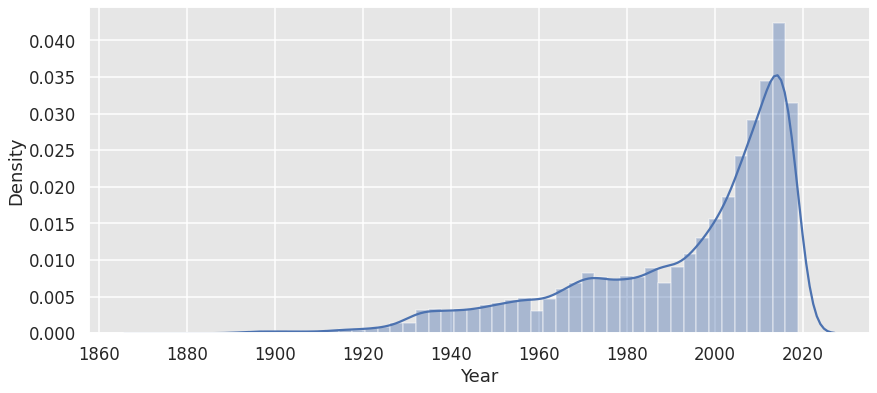

In [ ]:
sns.set(rc={'figure.figsize':(14, 6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"}) #sns.axes_style("whitegrid")

sns.distplot(df3.Year)

(1940.0, 2020.0)

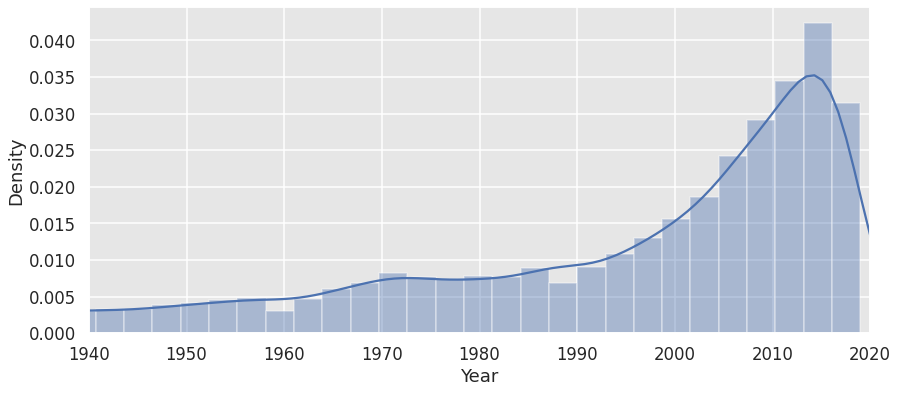

In [ ]:
#zooming in:
sns.distplot(df3.Year)
plt.xlim(1940, 2020)

In [ ]:
genre = df3.genre1.value_counts()
genre = pd.DataFrame(genre)
genre = genre.reset_index()
genre.rename({'index': 'genre', 'genre1':'Count'}, axis=1, inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

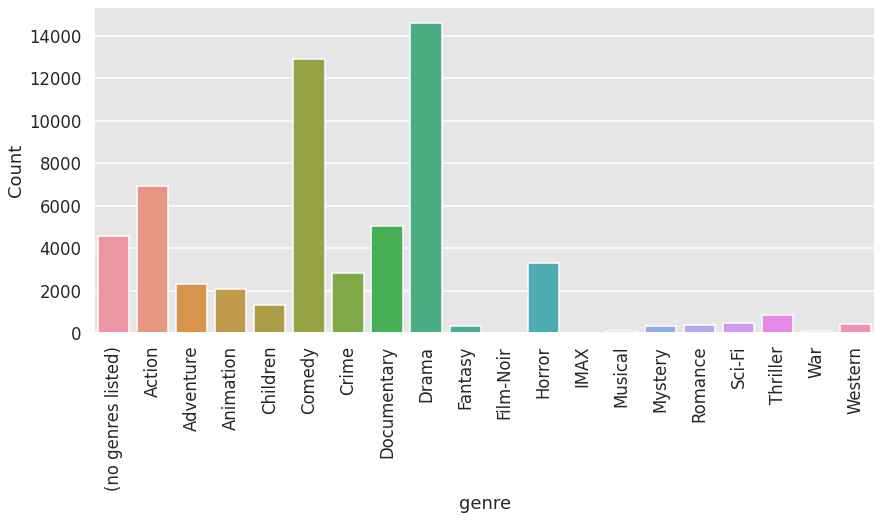

In [ ]:
sns.barplot(x = genre.genre, y=genre.Count)
plt.xticks(rotation=90)

In [ ]:
genre1 = df3.groupby('genre1')['rating_count'].mean()
genre1 = pd.DataFrame(genre1)
genre1 = genre1.reset_index()
genre1.rename({'rating_count':'avg_count_per_genre'}, axis=1, inplace=True)

Text(0, 0.5, '')

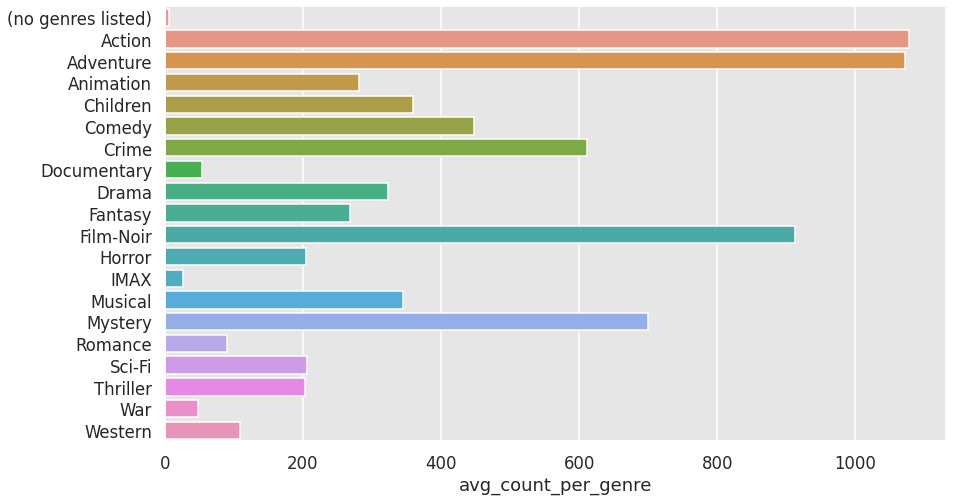

In [ ]:
sns.set(rc={'figure.figsize':(14, 8)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.barplot(x = genre1.avg_count_per_genre, y=genre1.genre1)
plt.ylabel("")

In [ ]:
cols = ['movieId', 'genre1']
b1 = df3[cols]
box_genre = df1.merge(b1, on='movieId', how='inner')

(-2.0, 7.0)

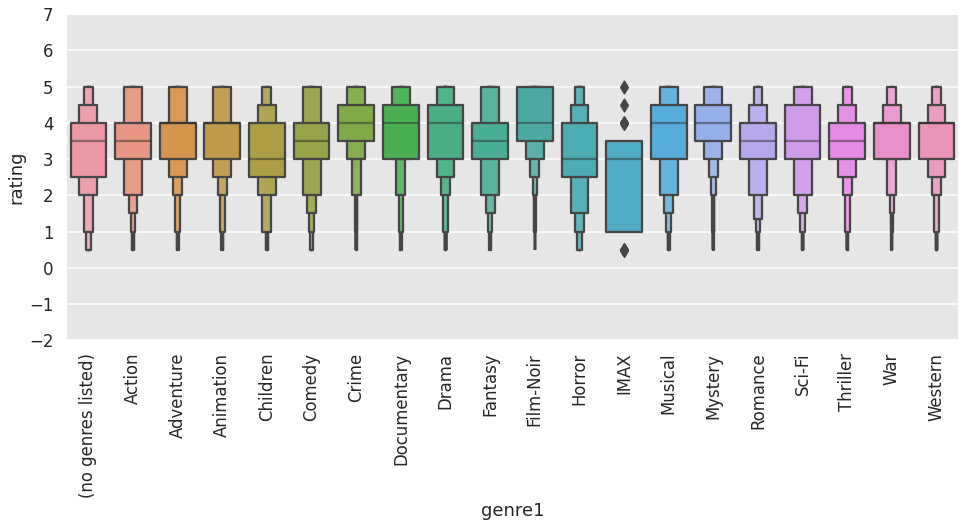

In [ ]:
sns.set(rc={'figure.figsize':(16, 6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.boxenplot(x=box_genre.genre1, y=box_genre.rating, data=box_genre)
plt.xticks(rotation=90)
plt.ylim(-2, 7)

In [ ]:
df = df2[df2['genre1']=='Comedy']

In [ ]:
from wordcloud import WordCloud

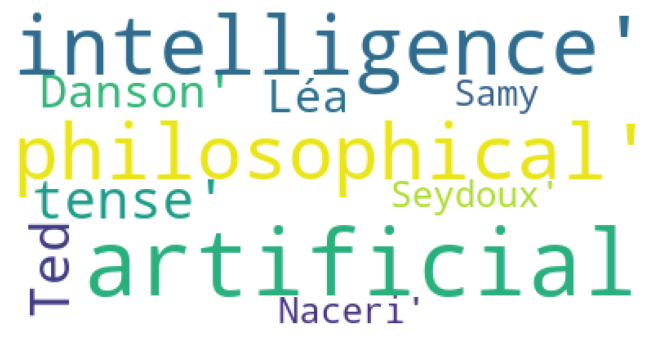

In [ ]:
#Drama
text = df['tag'].values 

wordcloud = WordCloud(background_color ='white', relative_scaling=0.5).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

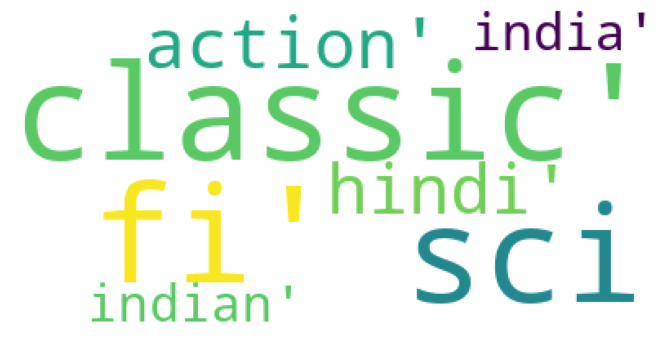

In [ ]:
#Action
text = df['tag'].values 

wordcloud = WordCloud(background_color ='white').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

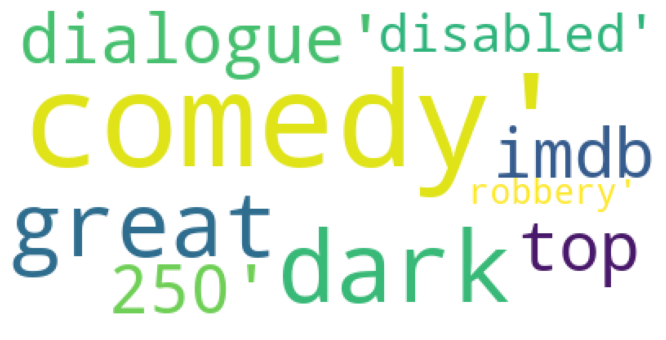

In [ ]:
#Comedy
text = df['tag'].values 

wordcloud = WordCloud(background_color ='white').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#movie produced each year for each genre (stacked bar)
genre_by_year = df3.groupby(['Year', 'genre1'])['title'].count().reset_index()
genre_by_year  = pd.DataFrame(genre_by_year)
genre_by_year.tail()

,Year,genre1,title
2695,2019,Romance,7
2696,2019,Sci-Fi,13
2697,2019,Thriller,30
2698,2019,War,1
2699,2019,Western,5


In [ ]:
genre_by_year.shape

(2700, 3)

In [ ]:
#since we already seen that move of the movies were after 1940s - 1950's, so we filter out every thing before it
genre_by_year1 = genre_by_year[genre_by_year['Year']>='1945']
genre_by_year1.shape

(1500, 3)

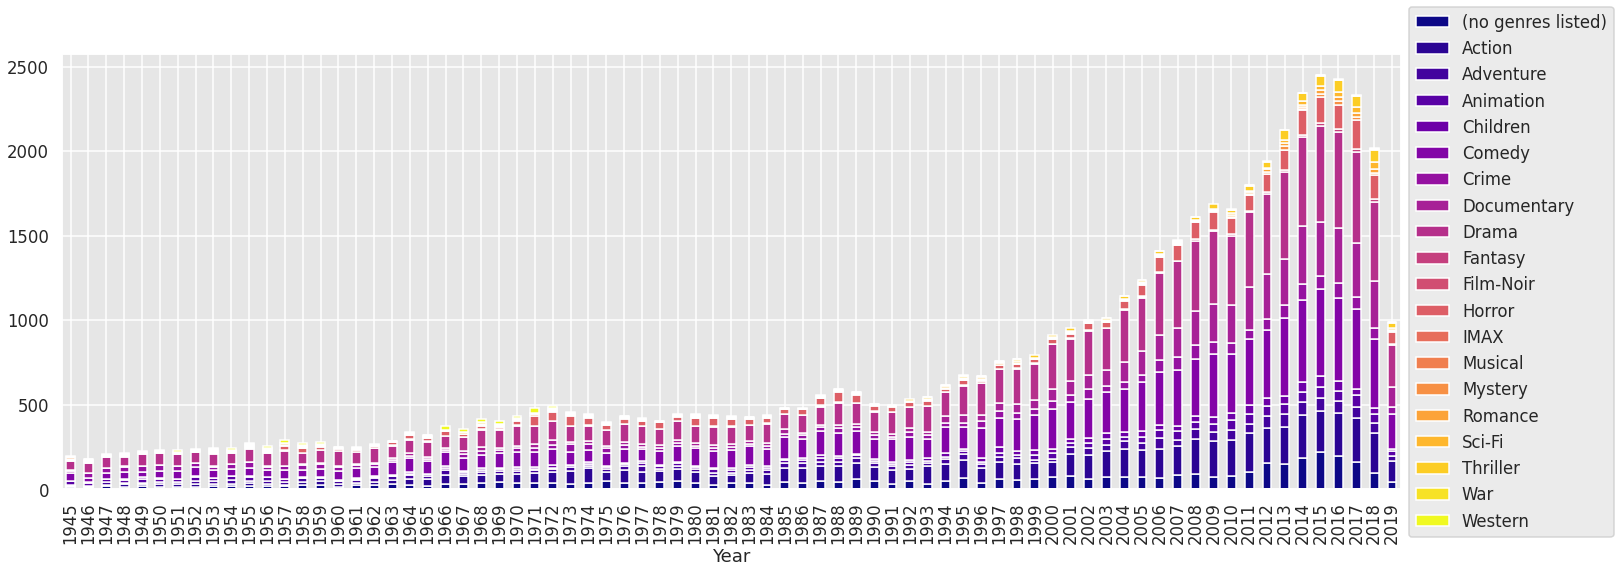

In [ ]:
sns.set(rc={'figure.figsize':(24, 8)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_pivot = pd.pivot_table(genre_by_year1, index='Year', columns='genre1', values='title')
df_pivot.plot.bar(stacked=True, colormap='plasma')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
#genre popularity each year
genre_pop = df3.groupby(['genre1', 'Year' ])['avg_rating'].mean().reset_index()
genre_pop  = pd.DataFrame(genre_pop)
genre_pop.tail()

,genre1,Year,avg_rating
2695,Western,2015,3.866135
2696,Western,2016,2.200000
2697,Western,2017,2.806809
2698,Western,2018,3.018092
2699,Western,2019,2.267031


In [ ]:
dfgen2 = genre_pop1[genre_pop1['genre1']=='Comedy']
dfgen3 = genre_pop1[genre_pop1['genre1']=='Documentary']
dfgen4 = genre_pop1[genre_pop1['genre1']=='Horror']
dfgen = genre_pop1[genre_pop1['genre1']=='Action']
dfgen1 = genre_pop1[genre_pop1['genre1']=='Drama']
dk.head()

,genre1,Year,avg_rating
195,Action,1945,2.878333
196,Action,1946,2.685312
197,Action,1947,2.679630
198,Action,1948,3.148062
199,Action,1949,2.890191


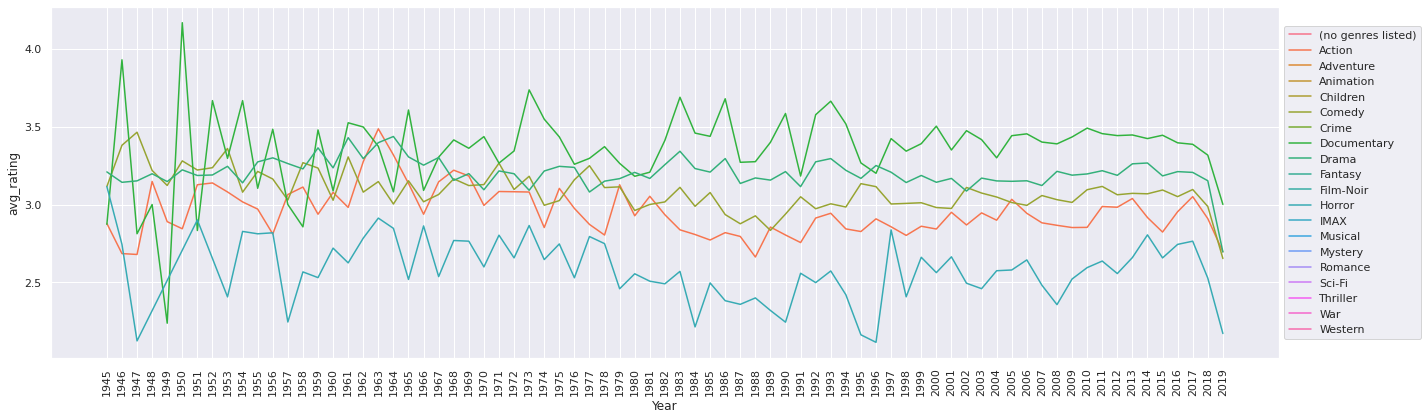

In [ ]:
sns.set(rc={'figure.figsize':(20, 6)})
sns.lineplot(x="Year", y="avg_rating", hue='genre1', data=dk, palette = 'husl' )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90) 
plt.tight_layout()

In [ ]:
#top 10 movies with rating count via swarmplot
top10_mov = df3.sort_values(by=['rating_count'], ascending=False)
top10_mov = top10_mov.head(10)
cols = ['movieId', 'title']
top10mov = top10_mov[cols]
top10mov.head()

,movieId,title
351,356,Forrest Gump (1994)
314,318,"Shawshank Redemption, The (1994)"
292,296,Pulp Fiction (1994)
585,593,"Silence of the Lambs, The (1991)"
2480,2571,"Matrix, The (1999)"


In [ ]:
top10mov = top10mov.merge(df1, on = 'movieId', how='inner')
top10mov.shape

(700675, 4)

In [ ]:
top10mov.head()

,movieId,title,userId,rating
0,356,Forrest Gump (1994),2,4.5
1,356,Forrest Gump (1994),3,4.0
2,356,Forrest Gump (1994),5,4.0
3,356,Forrest Gump (1994),8,5.0
4,356,Forrest Gump (1994),9,5.0


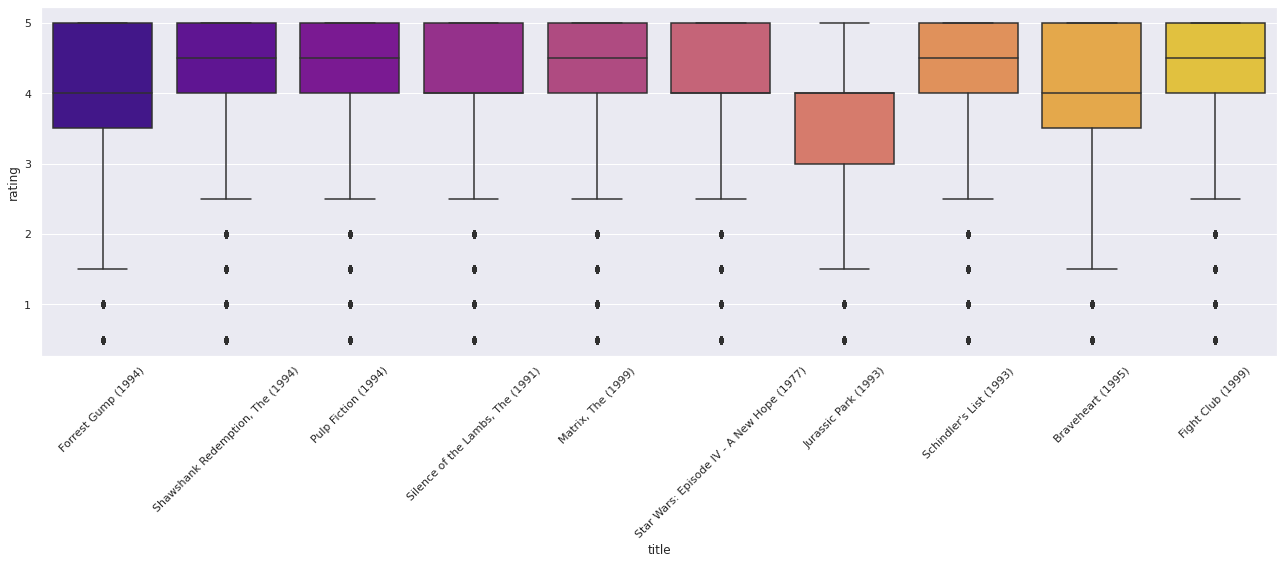

In [ ]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.boxplot(x='title', y='rating', data=top10mov, palette ='plasma')
plt.xticks(rotation=45) 
plt.tight_layout()

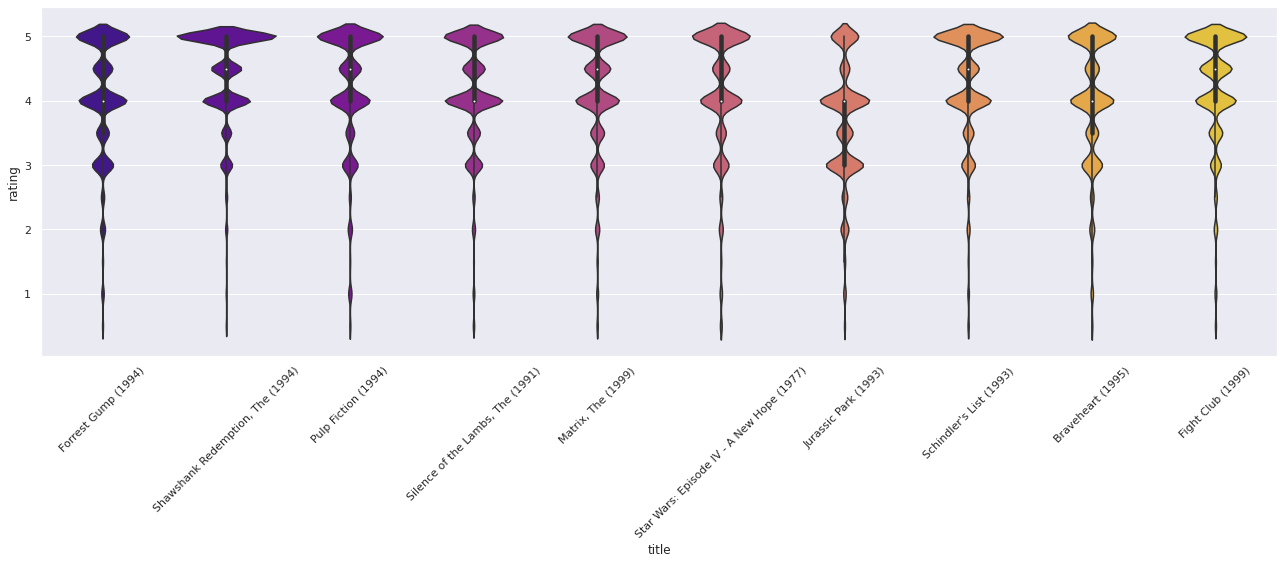

In [ ]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.violinplot(x='title', y='rating', data=top10mov, palette ='plasma')
plt.xticks(rotation=45) 
plt.tight_layout()

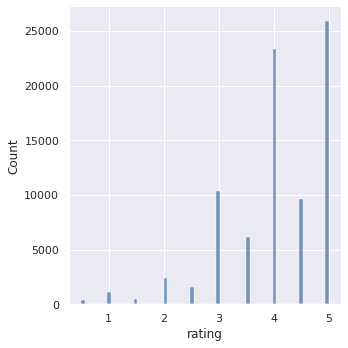

In [ ]:
kkk = top10mov[top10mov['movieId']==356]
sns.displot(kkk.rating)

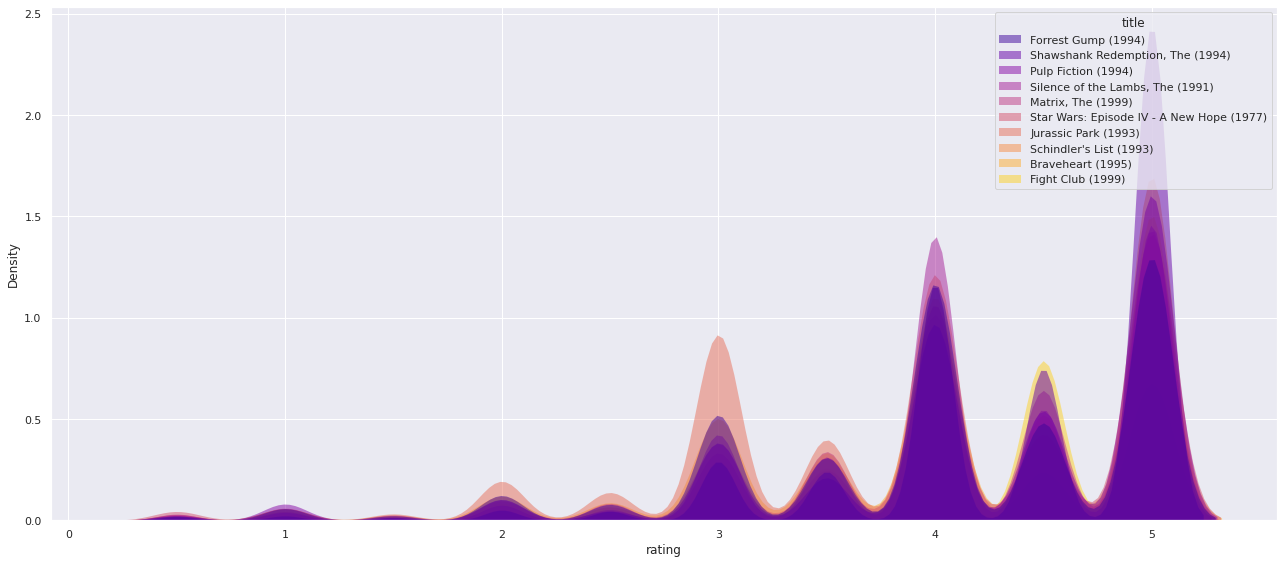

In [ ]:
sns.kdeplot(data=top10mov, x='rating', hue='title', fill=True, common_norm=False, palette="plasma", alpha=.5, linewidth=0,)
plt.tight_layout()

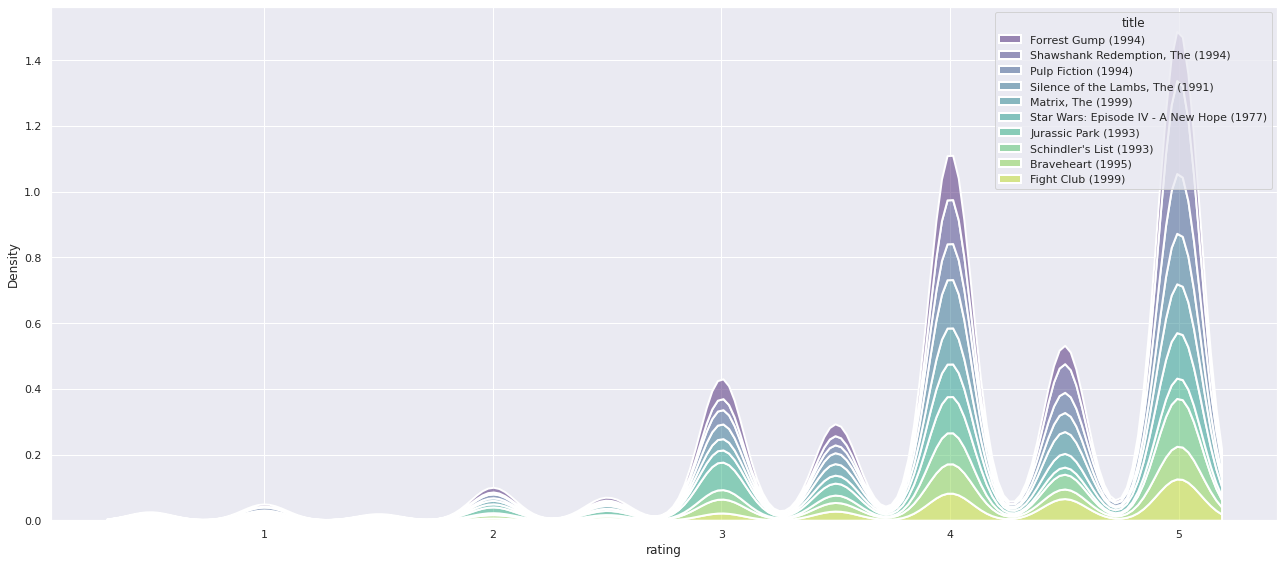

In [ ]:
sns.kdeplot(data=top10mov, x='rating', hue='title', alpha=.5, linewidth=2, multiple="stack", palette="viridis")
plt.tight_layout()

In [ ]:
#verify if top rates are also top commentors (from df_movie, df_user)

In [ ]:
top100tag_usr = user_tagcount.sort_values(by=['tag_count'], ascending=False).reset_index()
del top100tag_usr['index']
top100tag_usr.head(3)

,userId,tag_count
0,6550,183356
1,21096,20317
2,62199,13700


In [ ]:
sum(user_tagcount.tag_count)
kk = top100tag_usr.iloc[:1, :]
kk1 = top100tag_usr.iloc[:10, :]
kk2 = top100tag_usr.iloc[:20, :]
kk3 = top100tag_usr.iloc[:100, :]

In [ ]:
print('Top 1 user tags: ',((sum(kkk.tag_count)/sum(user_tagcount.tag_count))*100), '%')
print('Top 10 user tags: ',((sum(kk1.tag_count)/sum(user_tagcount.tag_count))*100), '%')
print('Top 20 user tags: ',((sum(kk2.tag_count)/sum(user_tagcount.tag_count))*100), '%')
print('Top 100 user tags: ',((sum(kk3.tag_count)/sum(user_tagcount.tag_count))*100), '%')

Top 1 user tags:  16.770202241929347 %
Top 10 user tags:  26.287700851699007 %
Top 20 user tags:  31.79136666959347 %
Top 100 user tags:  49.57369318348114 %


In [ ]:
#now lets verify if top 100 users are also avid raters
top100rat_usr = df_user.sort_values(by=['rating_count'], ascending=False).reset_index()
del top100rat_usr['index']
top100rat_usr.head(3)

,userId,rating,rating_count
0,72315,3.080601,32202
1,80974,3.280290,9178
2,137293,3.184001,8913


In [ ]:
k = sum(df_user.rating_count)
kk = top100rat_usr.iloc[:1, :]
kk1 = top100rat_usr.iloc[:10, :]
kk2 = top100rat_usr.iloc[:20, :]
kk3 = top100rat_usr.iloc[:100, :]
kk4 = top100rat_usr.iloc[:1000, :]
kk5 = top100rat_usr.iloc[:1625, :]

In [ ]:
print('Top 1 user rating: ',((sum(kk.rating_count)/k)*100), '%')
print('Top 10 user rating: ',((sum(kk1.rating_count)/k)*100), '%')
print('Top 20 user rating: ',((sum(kk2.rating_count)/k)*100), '%')
print('Top 100 user rating: ',((sum(kk3.rating_count)/k)*100), '%')
print('Top 1000 user rating: ',((sum(kk4.rating_count)/k)*100), '%')
print('Top 1% user rating: ',((sum(kk5.rating_count)/k)*100), '%')

Top 1 user rating:  0.12880751053145997 %
Top 10 user rating:  0.3872225285543915 %
Top 20 user rating:  0.594661740285387 %
Top 100 user rating:  1.824157068203141 %
Top 1000 user rating:  8.820970480312175 %
Top 1% user rating:  12.137165878769661 %


In [ ]:
user_rat100 = top100tag_usr.iloc[:100, :]
user_tag100 = top100rat_usr.iloc[:100, :]
hipo_rater_tager = user_tag100.merge(user_rat100, on = 'userId', how='inner')
hipo_rater_tager

,userId,rating,rating_count,tag_count
0,33844,2.580124,7919,4029
1,53837,3.041009,3926,3150
2,62199,2.974560,3754,13700
3,140838,3.023209,3727,1861
4,86462,2.888162,3286,1733


## so the avid raters are not same as top commentors, interesting -_-

In [ ]:
#top 10% rates, favourite genres (from df_movie, df_user)
#we will take top 1% user which account for 12% of the rating to see the favorite genre
kk5.shape

(1625, 3)

In [ ]:
top1_perc = df1.merge(kk5, on = 'userId', how='inner')
top1_perc.head()

,userId,movieId,rating_x,rating_y,rating_count
0,187,1,3.5,3.876712,1387
1,187,2,3.5,3.876712,1387
2,187,3,3.0,3.876712,1387
3,187,13,4.5,3.876712,1387
4,187,19,4.5,3.876712,1387


In [ ]:
top1_perc.shape

(3034303, 5)

In [ ]:
col = ['movieId', 'genre1']
gen =  movie_tagcount[col]
top1_perc_gen = top1_perc.merge(gen, on = 'movieId', how='inner')
top1_perc_gen.head()

,userId,movieId,rating_x,rating_y,rating_count,genre1
0,187,1,3.5,3.876712,1387,Adventure
1,548,1,4.5,3.242528,3212,Adventure
2,626,1,4.5,3.322034,1888,Adventure
3,757,1,3.0,3.622140,1355,Adventure
4,803,1,5.0,3.529160,1286,Adventure


In [ ]:
dfd = top1_perc_gen.groupby('genre1')['rating_x'].count().reset_index()
dfd.head()

,genre1,rating_x
0,(no genres listed),6876
1,Action,729919
2,Adventure,227413
3,Animation,66971
4,Children,54588


In [ ]:
dft = top1_perc_gen.groupby('genre1')['rating_x'].mean().reset_index()
dft = dft.sort_values(by=['rating_x'], ascending=False).reset_index()
del dft['index']
dft.head()

,genre1,rating_x
0,Film-Noir,3.753638
1,Documentary,3.551419
2,Mystery,3.499520
3,Crime,3.470792
4,Western,3.393380


In [ ]:
dft.tail()

,genre1,rating_x
15,Romance,3.068471
16,Sci-Fi,3.056829
17,Children,2.882492
18,Horror,2.848837
19,IMAX,2.357143


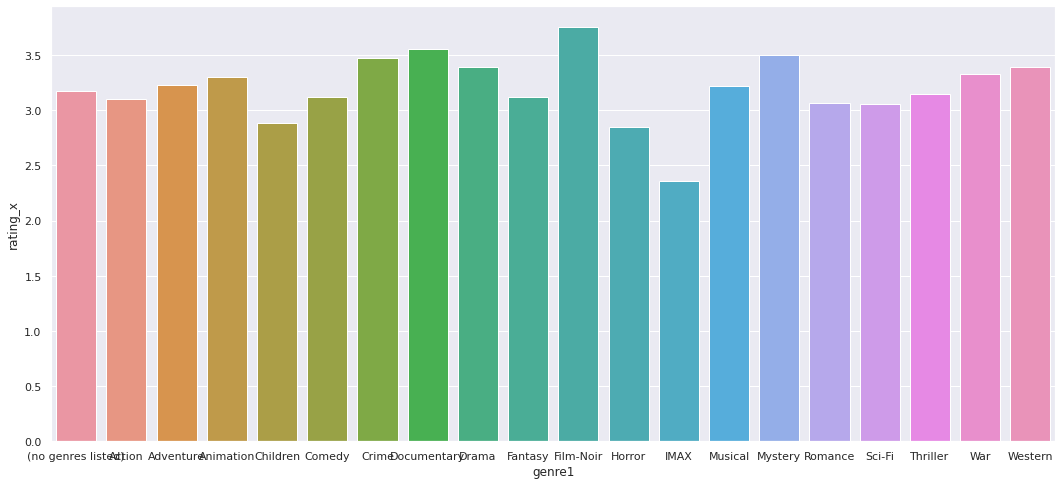

In [ ]:
sns.barplot(x='genre1', y='rating_x', data=dft)

In [ ]:
dfdd = dfd.merge(dft, on = 'genre1', how='inner') #to verify if the rating_count has effect/bias on avg_rating for a genre
dfdd

,genre1,rating_x_x,rating_x_y
0,(no genres listed),6876,3.170739
1,Action,729919,3.101946
2,Adventure,227413,3.233342
3,Animation,66971,3.298353
4,Children,54588,2.882492
5,Comedy,746880,3.121686
6,Crime,203334,3.470792
7,Documentary,66036,3.551419
8,Drama,658864,3.392315
9,Fantasy,14107,3.120295


In [ ]:
#75% of the movies has less than average tag count, which give rise to question if they are less popular or new?
#moreover are more popular movies have more tag_count? --> Lets verify this too with visuals and then with further analysis
movie_tagcount.head(3)

,movieId,tag_count,genre_count,genre1
0,1,697,5,Adventure
1,2,180,3,Adventure
2,3,29,2,Comedy


In [ ]:
gr_than_avgtag = movie_tagcount[movie_tagcount['tag_count']>24]
gr_than_avgtag.shape

(6484, 4)

In [ ]:
ls_than_avgtag = movie_tagcount[movie_tagcount['tag_count']<=24]
ls_than_avgtag.shape

(38767, 4)

In [ ]:
gr_than_avgtag = gr_than_avgtag.merge(df_movie, on = 'movieId', how='inner') 
gr_than_avgtag = gr_than_avgtag.merge(yr, on = 'movieId', how='inner') 
gr_than_avgtag.head()

,movieId,tag_count,genre_count,genre1,rating,rating_count,Year
0,1,697,5,Adventure,3.893708,57309,1995
1,2,180,3,Adventure,3.251527,24228,1995
2,3,29,2,Comedy,3.142028,11804,1995
3,6,621,3,Action,3.854909,24588,1995
4,7,73,2,Comedy,3.363666,12132,1995


In [ ]:
ls_than_avgtag = ls_than_avgtag.merge(df_movie, on = 'movieId', how='inner') 
ls_than_avgtag = ls_than_avgtag.merge(yr, on = 'movieId', how='inner') 
ls_than_avgtag.head()

,movieId,tag_count,genre_count,genre1,rating,rating_count,Year
0,4,11,3,Comedy,2.853547,2523,1995
1,5,24,1,Comedy,3.058434,11714,1995
2,8,7,2,Adventure,3.114583,1344,1995
3,9,13,1,Action,2.992051,3711,1995
4,12,21,2,Comedy,2.624566,3741,1995


In [ ]:
gr_than_avgtag.describe(include='all')

,movieId,tag_count,genre_count,genre1,rating,rating_count,Year
count,6484.000000,6484.000000,6484.000000,6484,6484.000000,6484.000000,6475
unique,NaN,NaN,NaN,19,NaN,NaN,105
top,NaN,NaN,NaN,Drama,NaN,NaN,2006
freq,NaN,NaN,NaN,1775,NaN,NaN,238
mean,50893.038248,132.802128,2.408698,NaN,3.405811,3429.190932,NaN
std,56746.985040,257.431461,1.146721,NaN,0.442924,6721.591819,NaN
min,1.000000,25.000000,0.000000,NaN,0.500000,1.000000,NaN
25%,3702.750000,34.000000,2.000000,NaN,3.145446,315.750000,NaN
50%,27757.500000,55.000000,2.000000,NaN,3.471466,1019.000000,NaN
75%,88193.000000,122.000000,3.000000,NaN,3.735086,3411.750000,NaN


In [ ]:
ls_than_avgtag.describe(include='all')

,movieId,tag_count,genre_count,genre1,rating,rating_count,Year
count,35391.000000,35391.000000,35391.000000,35391,35391.000000,35391.000000,35256
unique,NaN,NaN,NaN,20,NaN,NaN,134
top,NaN,NaN,NaN,Drama,NaN,NaN,2015
freq,NaN,NaN,NaN,9231,NaN,NaN,1537
mean,112491.983244,6.284733,1.761521,NaN,3.056689,75.776440,NaN
std,60335.694439,5.500961,1.006495,NaN,0.671884,326.226738,NaN
min,4.000000,1.000000,0.000000,NaN,0.500000,1.000000,NaN
25%,72259.500000,2.000000,1.000000,NaN,2.704558,3.000000,NaN
50%,125852.000000,4.000000,2.000000,NaN,3.125000,8.000000,NaN
75%,162711.000000,9.000000,2.000000,NaN,3.500000,32.000000,NaN


In [ ]:
avg_rating_perc = ((3.405-3.056)/3.056) *100
avg_rating_count = ((3429.190-75.776)/3429.190) *100
tag_avg_count = ((138.80 - 6.284)/138.80) *100
print('Movies with greater than average tags count have ', avg_rating_perc, '% better avg rating')
print('Movies with greater than average tags count have ', avg_rating_count, '% better rating count')
print('Movies with greater than average tags count have ', tag_avg_count, '% better tag count')

Movies with greater than average tags count have  11.420157068062819 % better avg rating
Movies with greater than average tags count have  97.79026533962832 % better rating count
Movies with greater than average tags count have  95.47262247838617 % better tag count


###hence proved that movies with more than average tag count are more popular and so do popular movies have more rating counts and tags counts aswell.

In [ ]:
#hence proved that movies with more than average tag count are more popular and so do popular movies have more rating counts and tags counts aswell.

In [ ]:
genre1 = df3.groupby('genre1')['rating_count'].mean()
genre1 = pd.DataFrame(genre1)
genre1 = genre1.reset_index()
genre1.rename({'rating_count':'avg_count_per_genre'}, axis=1, inplace=True)
genre1.head()

In [ ]:
cols = ['movieId', 'genre1', 'Year']
b1 = df3[cols]
box_genre = b1.merge(df_movie, on='movieId', how='inner')
box_genre.head()


In [ ]:
cols = ['Year', 'genre1', 'rating']
box_genre1 = box_genre[cols]
box_genre1.head()

,Year,genre1,rating
0,1995,Adventure,3.893708
1,1995,Adventure,3.251527
2,1995,Comedy,3.142028
3,1995,Comedy,2.853547
4,1995,Comedy,3.058434


In [ ]:
d1 = box_genre1[box_genre1['Year']>'2009']

In [ ]:
para = d1.pivot_table(index='genre1', columns='Year', values='rating', fill_value=0)

In [ ]:
para.head()

Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
genre1,,,,,,,,,,
(no genres listed),3.260390,3.050985,3.325552,3.446889,3.331479,3.171583,3.233520,2.944177,2.951294,2.368979
Action,2.853503,2.987310,2.982647,3.038689,2.916713,2.823424,2.953948,3.050806,2.909679,2.696809
Adventure,3.082370,3.045209,2.921004,3.141201,2.959646,3.172589,2.967612,3.006581,2.777660,2.678540
Animation,3.071794,3.143026,2.866044,3.208282,3.033636,3.022326,3.268951,2.958446,3.023478,3.010668
Children,3.415554,3.161533,3.139010,3.433518,3.236923,3.268039,3.160625,3.038861,2.813181,2.547763


In [ ]:
para1 = para.reset_index()
#del para1['Year']
para1.head()

Year,genre1,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,(no genres listed),3.260390,3.050985,3.325552,3.446889,3.331479,3.171583,3.233520,2.944177,2.951294,2.368979
1,Action,2.853503,2.987310,2.982647,3.038689,2.916713,2.823424,2.953948,3.050806,2.909679,2.696809
2,Adventure,3.082370,3.045209,2.921004,3.141201,2.959646,3.172589,2.967612,3.006581,2.777660,2.678540
3,Animation,3.071794,3.143026,2.866044,3.208282,3.033636,3.022326,3.268951,2.958446,3.023478,3.010668
4,Children,3.415554,3.161533,3.139010,3.433518,3.236923,3.268039,3.160625,3.038861,2.813181,2.547763


In [ ]:
para1['genre2'] = para1.genre1.cat.codes

In [ ]:
para1.head(2)

Year,genre1,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,genre2
0,(no genres listed),3.260390,3.050985,3.325552,3.446889,3.331479,3.171583,3.233520,2.944177,2.951294,2.368979,0
1,Action,2.853503,2.987310,2.982647,3.038689,2.916713,2.823424,2.953948,3.050806,2.909679,2.696809,1


In [ ]:
import plotly.express as px

In [ ]:
fig = px.parallel_coordinates(para1, color="genre2",
                              dimensions=['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'],
                              color_continuous_scale=px.colors.diverging.Portland_r)
fig.show() 

In [ ]:
d2 = box_genre1[(box_genre1['Year']>'1999') & (box_genre1['Year']<'2010')]
d3 = box_genre1[(box_genre1['Year']>'1989') & (box_genre1['Year']<'2000')]
para2 = d2.pivot_table(index='genre1', columns='Year', values='rating', fill_value=0)
para3 = d3.pivot_table(index='genre1', columns='Year', values='rating', fill_value=0)
para22 = para2.reset_index()
para33 = para3.reset_index()
para22['genre2'] = para22.genre1.cat.codes
para33['genre2'] = para33.genre1.cat.codes

In [ ]:
fig = px.parallel_coordinates(para22, color="genre2",
                              dimensions=['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009'],
                              color_continuous_scale=px.colors.sequential.Jet)
fig.show() 

In [ ]:
fig = px.parallel_coordinates(para33, color="genre2",
                              dimensions=['1993', '1994', '1995', '1996', '1997'],
                              color_continuous_scale=px.colors.sequential.Rainbow)
fig.show() 

# Applying ML

Now i will use the 25M rating dataset to apply pivot and create U,V martix of userId as rows and movieId as columns. Based on these pivots (by chunks) i will apply PCA to reduce no of features i.e. movie columns.

Then we will upload the data to database and apply kmeans and Nearest Neighbour algortihms on it to group users as per similarity and to find the closest users for each user

In [ ]:
162541/25

6501.64

In [ ]:
df1.shape

(25000095, 3)

In [ ]:
#creating multiple chunks for pivoting
tst = df1[df1['userId']<=6750]
tst2 = df1[(df1['userId']>6750) & (df1['userId']<=13500)]
tst3 = df1[(df1['userId']>13500) & (df1['userId']<=20000)]
tst4 = df1[(df1['userId']>20000) & (df1['userId']<=26750)]
tst5 = df1[(df1['userId']>26750) & (df1['userId']<=33500)]
tst6 = df1[(df1['userId']>33500) & (df1['userId']<=40000)]
tst7 = df1[(df1['userId']>40000) & (df1['userId']<=46750)]
tst8 = df1[(df1['userId']>46750) & (df1['userId']<=53500)]
tst9 = df1[(df1['userId']>53500) & (df1['userId']<=60000)]
tst10 = df1[(df1['userId']>60000) & (df1['userId']<=66750)]
tst11 = df1[(df1['userId']>66750) & (df1['userId']<=73500)]
tst12 = df1[(df1['userId']>73500) & (df1['userId']<=80000)]
tst13 = df1[(df1['userId']>80000) & (df1['userId']<=86750)]
tst14 = df1[(df1['userId']>86750) & (df1['userId']<=93500)]
tst15 = df1[(df1['userId']>93500) & (df1['userId']<=100500)]
tst16 = df1[(df1['userId']>100500) & (df1['userId']<=107200)]
tst17 = df1[(df1['userId']>107200) & (df1['userId']<=113700)]
tst18 = df1[(df1['userId']>113700) & (df1['userId']<=120500)]
tst19 = df1[(df1['userId']>120500) & (df1['userId']<=127500)]
tst20 = df1[(df1['userId']>127500) & (df1['userId']<=134500)]
tst21 = df1[(df1['userId']>134500) & (df1['userId']<=141000)]
tst22 = df1[(df1['userId']>141000) & (df1['userId']<=147500)]
tst23 = df1[(df1['userId']>147500) & (df1['userId']<=154000)]
tst24 = df1[(df1['userId']>154000) & (df1['userId']<=162541)]

In [ ]:
#csr matric to convert dataframe to numpy matrix and truncated SVD to apply PCA
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [ ]:
tst = [tst1, tst2, tst3, tst4, tst4, tst5, tst6, tst7, tst8, tst9, tst10, tst10, tst11, tst12, tst13, tst14, tst15, tst16, tst17, tst18, tst19, tst20, tst21, tst22, tst23, tst24]

In [ ]:
print(tst.shape)
pivot = tst.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
print(pivot.shape)
kay = csr_matrix(pivot.values)
svd = TruncatedSVD(n_components=20,random_state=42)
jay = svd.fit(kay)
print(jay.explained_variance_ratio_.sum())
jay_truncated = svd.fit_transform(kay)
col = ['userId']
dfn = pivot.reset_index()
df = dfn[col]
print(df.shape)
dfj = pd.DataFrame(jay_truncated)
dfq = pd.concat([df,dfj], axis=1)
dfq.tail()

In [ ]:
for tst in tst:
  print(tst.shape)
  pivot = tst.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
  print(pivot.shape)
  kay = csr_matrix(pivot.values)
  svd = TruncatedSVD(n_components=20,random_state=42)
  jay = svd.fit(kay)
  print(jay.explained_variance_ratio_.sum())
  jay_truncated = svd.fit_transform(kay)
  col = ['userId']
  dfn = pivot.reset_index()
  df = dfn[col]
  print(df.shape)
  dfj = pd.DataFrame(jay_truncated)
  dfq = pd.concat([df,dfj], axis=1)
  dfq.tail()
  dfq.to_csv('user162k.csv', index=False)

(1288294, 3)
(8541, 24540)
0.30000976189344336
(8541, 1)


,userId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
8536,162537,8.981634,-3.167873,-0.967647,2.477804,-0.950945,-1.169700,-4.702853,-2.532785,-2.309399,3.359087,-0.748039,1.900820,-2.106871,-1.109786,-0.300214,2.152255,1.177162,-0.084937,-3.119507,0.690961
8537,162538,16.158424,6.835508,-0.153725,-2.443342,1.042628,-5.295056,-10.121226,-0.374079,-3.819200,3.870078,-1.932782,4.383707,-0.606959,-0.273830,-1.197750,-0.152815,-0.453879,-3.390016,5.682952,-4.099171
8538,162539,8.508038,-4.413037,1.301188,-3.657601,-2.811846,-1.687776,2.903506,-1.234161,2.389989,-1.420688,-2.414542,1.105739,2.792035,-0.560146,0.219928,0.204812,-0.981647,0.880129,-0.594303,-0.508611
8539,162540,5.950325,6.611848,-0.593446,4.904362,-0.071323,-2.289889,-2.790182,1.521480,2.689449,-2.251725,1.181497,2.802252,0.488684,-3.412244,-0.251065,0.417582,-0.855270,0.628018,5.359266,-1.785814
8540,162541,20.570862,-1.284817,0.986339,-7.663809,-7.039603,0.023074,-1.017010,3.533426,-3.279393,0.626384,4.492527,1.981941,0.346881,3.325172,-2.040966,5.089881,-2.831664,5.062384,-1.410637,2.514724


In [ ]:
dfq.to_csv('user162k.csv', index=False)

In [ ]:
#creating sparse matrix and applying dimensionality reduction
kay = csr_matrix(pivot.values)
svd = TruncatedSVD(n_components=20,random_state=42)
jay = svd.fit(kay)

In [ ]:
jay.explained_variance_ratio_

array([0.10197745, 0.04490364, 0.02340242, 0.01952556, 0.01526483,
       0.01289878, 0.01299425, 0.00897853, 0.00799497, 0.00661766])

In [ ]:
jay.singular_values_[:10]

array([1581.18507659,  744.23557511,  556.5734452 ,  507.46638886,
        433.67107706,  402.58364718,  401.59991001,  332.50806541,
        314.07088795,  285.79527846])

In [ ]:
jay_truncated = svd.fit_transform(kay)

In [ ]:
df = pd.read_csv('/user162k.csv')

In [ ]:
df_piv.tail(3)

,userId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
8538,162539,8.508038,-4.413037,1.301188,-3.657601,-2.811846,-1.687776,2.903506,-1.234161,2.389989,-1.420688,-2.414542,1.105739,2.792035,-0.560146,0.219928,0.204812,-0.981647,0.880129,-0.594303,-0.508611
8539,162540,5.950325,6.611848,-0.593446,4.904362,-0.071323,-2.289889,-2.790182,1.521480,2.689449,-2.251725,1.181497,2.802252,0.488684,-3.412244,-0.251065,0.417582,-0.855270,0.628018,5.359266,-1.785814
8540,162541,20.570862,-1.284817,0.986339,-7.663809,-7.039603,0.023074,-1.017010,3.533426,-3.279393,0.626384,4.492527,1.981941,0.346881,3.325172,-2.040966,5.089881,-2.831664,5.062384,-1.410637,2.514724


In [ ]:
df_piv.shape

(162541, 21)

### Applying Kmeans to group users

I selected 20 clusters due to the number of available genres are 20. So i think 20 will be appropiate number of clusters as there will be atleast fan following of 1 genre by each user

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=0).fit(df_piv)

In [ ]:
h = kmeans.labels_
h.shape

(162541,)

In [ ]:
km = pd.DataFrame(h)
km.head()

In [ ]:
km.value_counts()

6     8705
14    8649
2     8542
10    8401
4     8242
16    8235
7     8229
1     8211
19    8181
9     8135
17    8085
5     8071
12    7994
15    7946
3     7913
8     7841
11    7838
18    7784
13    7779
0     7760
dtype: int64

In [ ]:
cols = ['userId']
df_km = df_piv[cols]
df_km = df_km.reset_index(drop=True)
km = km.reset_index(drop=True)

In [ ]:
df_km = df_km.join(km)
df_km.head(2)

,userId,0
0,1,6
1,2,6


In [ ]:
df_km.to_csv('kmeans_tag.csv', index=False)

### Applying NearestNeighbors clustering

In [ ]:
#check KNN too
from sklearn.neighbors import NearestNeighbors
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')

In [ ]:
knn_model.fit(df_piv)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
ch = df_piv.iloc[11000:11001, :]
ch

,userId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
4250,11001,41.415367,22.422241,0.482582,17.085108,0.928269,1.808947,-15.430146,20.288938,-7.308579,-3.423177,8.321872,-4.850489,-0.718839,9.438086,-6.382048,-4.479197,6.79031,9.881773,-4.61158,7.294431


In [ ]:
distances, indices = knn_model.kneighbors(ch, n_neighbors=5)

In [ ]:
distances

array([[0.00000000e+00, 3.37919562e-06, 3.47658161e-06, 4.45288928e-06,
        4.54999585e-06]])

In [ ]:
indices

array([[11000, 10532, 10642,  7363, 10017]])

In [ ]:
indices[:, 1:]

array([[10532, 10642,  7363, 10017]])

In [ ]:
j = pd.DataFrame()
for i in range(len(arr)):
  k = arr[i] #get value of indices
  n = df[df['userId']==k] #fetch result of movie rated by yser **select * from rating where userId=n**
  j.appned(n) #append all data
pivot = j.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0) #pivot of users and movies

In [ ]:
ki = df_piv.iloc[:100, :5]

In [ ]:
k2 = ki.describe()

In [ ]:
k2.shape

(8, 5)

In [ ]:
k3 = k2.iloc[1:2, :].values
k3

array([[50.5       , 13.2195128 ,  0.45004004, -1.61290754, -2.05242839]])

In [ ]:
k4 = k2.columns
k4

Index(['userId', '0', '1', '2', '3'], dtype='object')

In [ ]:
k5 = pd.DataFrame(k4)
k5['avg_rating'] = k3.T
k5

,0,avg_rating
0,userId,50.500000
1,0,13.219513
2,1,0.450040
3,2,-1.612908
4,3,-2.052428


## Some visuals

In [ ]:
d = np.random.randint(0, 162541, size=500) #selecting 5000 random sample for visualization
vis_df = kmeans_df.loc[d]

In [ ]:
dfv = df1.merge(vis_df, on = 'userId', how='inner')
dfv.shape

(68750, 4)

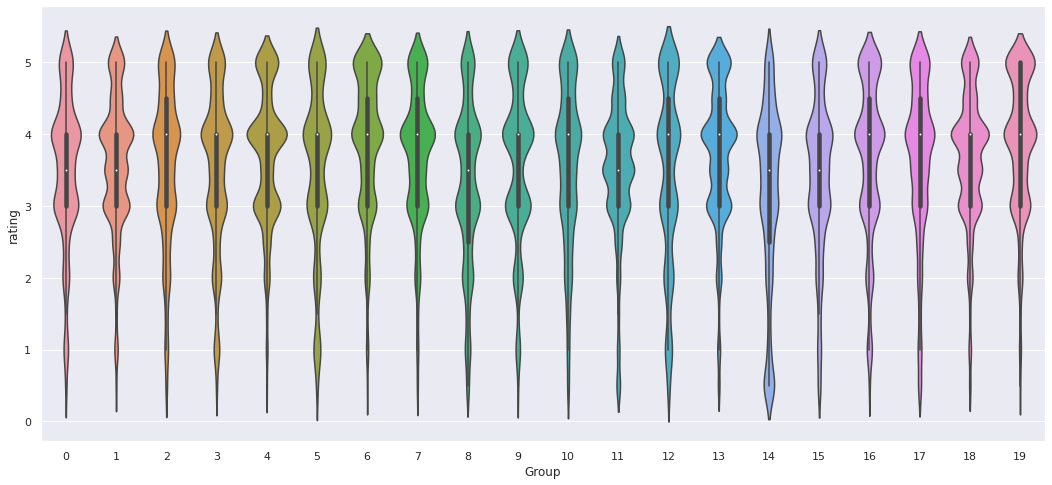

In [ ]:
sns.violinplot(x="Group",y="rating", data=dfv)

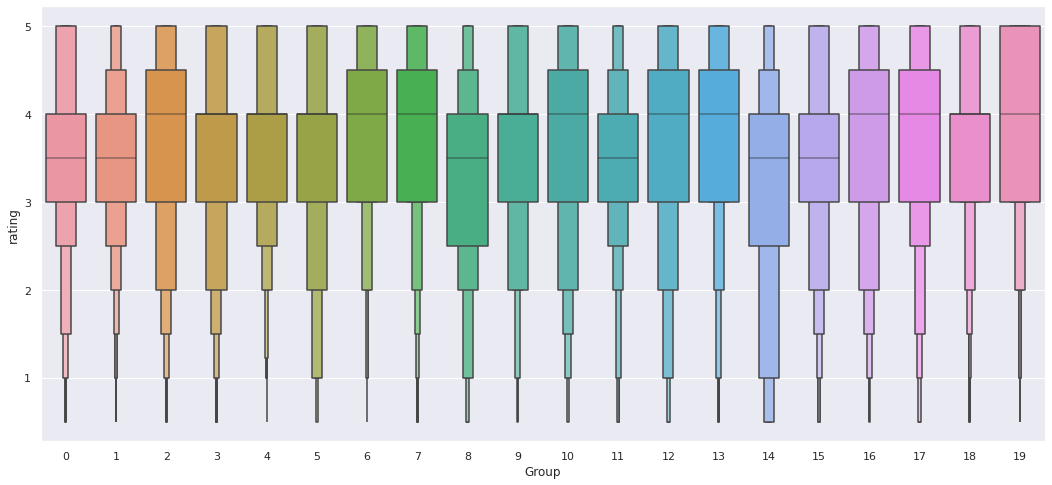

In [ ]:
sns.boxenplot(x="Group",y="rating", data=dfv)

In [ ]:
dfv = kmeans_df.merge(PCA_df, on = 'userId', how='inner')
dfv.shape

(162541, 22)

In [ ]:
d = np.random.randint(0, 162541, size=5000) #selecting 5000 random sample for visualization
vis_df = dfv.loc[d]

In [ ]:
vis_df.head(2)

,userId,Group,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
40112,40113,4,7.471,2.710,-5.063,0.822,-0.136,-2.778,1.995,-0.508,1.514,-1.272,0.894,-0.238,-0.683,-0.419,0.047,1.754,-0.527,0.552,-0.373,-0.464
73452,73453,13,5.078,-1.824,-0.850,-1.897,2.248,0.318,1.587,0.666,1.632,-1.373,1.814,3.365,-3.448,1.303,-0.703,-0.665,0.117,0.936,-1.385,0.254


In [ ]:
vis_df.columns

Index(['userId', 'Group', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'],
      dtype='object')

In [ ]:
vis_df['Group'].value_counts()

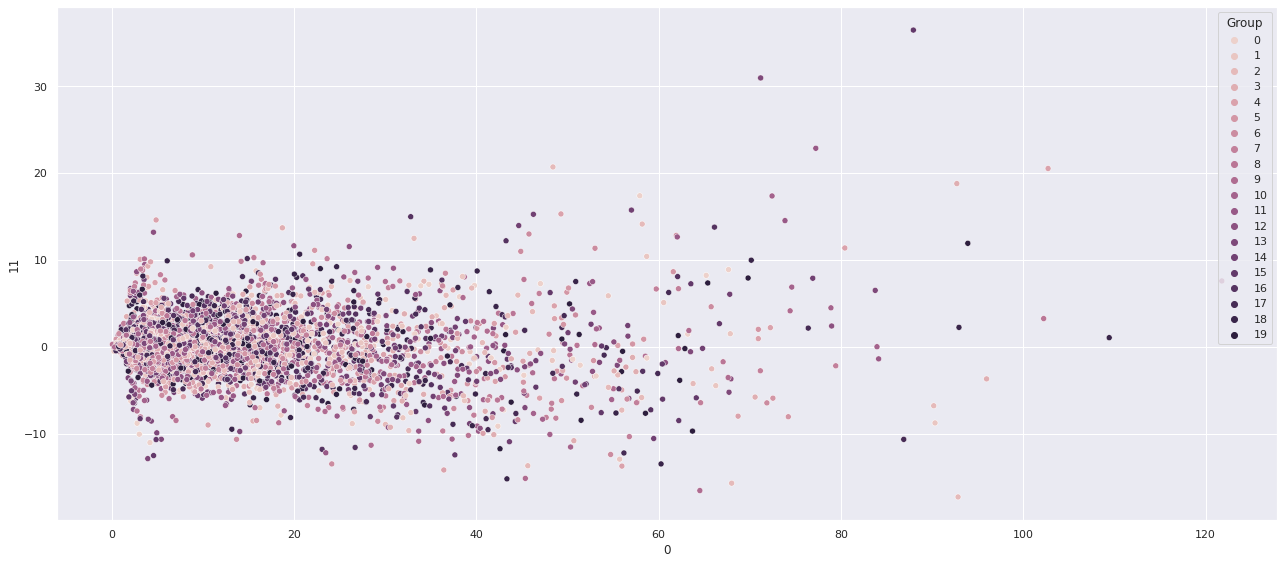

In [ ]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.scatterplot(x=vis_df['0'], y=vis_df['11'], hue=vis_df.Group, data=vis_df, legend="full")
plt.tight_layout()

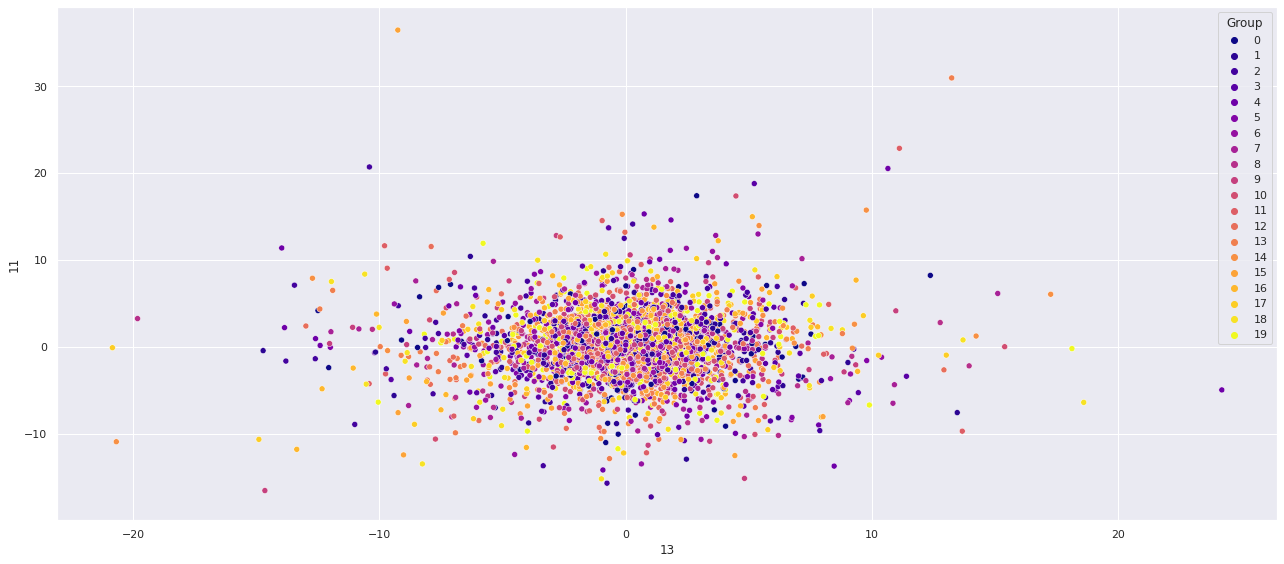

In [ ]:

sns.set(rc={'figure.figsize':(18, 8)})
sns.scatterplot(x=vis_df['13'], y=vis_df['11'], hue=vis_df.Group, data=vis_df, legend="full", palette='plasma')
plt.tight_layout()